In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

import internal_ref as ref

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso



/Users/allandong/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
CDC = ref.Home + '/df_final.csv'
labor = ref.Home + '/labor.csv'
hi = ref.Home + '/HI.csv'

df_CDC = pd.read_csv(CDC, dtype={'County Code' : int})
df_labor = pd.read_csv(labor, dtype={'series_id' : str, 
                                     'year' : int, 
                                     'period' : str, 
                                     'value' : object,
                                     'footnote_codes' : str,
                                     'area_code': str,
                                     'series_title' : str,
                                     'area_text' : str})
df_hi = pd.read_csv(hi)

/Users/allandong/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [183]:
df_CDC.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Notes'], axis =1, inplace=True)

cdcColumns = ['County', 'County_Code', 'Race', 'Race_Code',
       'ICD_10_130_Infants',
       'ICD_10_130_Infants_Code', 'Cause_of_death',
       'Cause_of_death_Code', 'Gender', 'Gender_Code', 'Deaths', 'Births',
       'Death_Rate', 'Year']
df_CDC.columns = cdcColumns

In [184]:
df_labor_cty = df_labor[df_labor.area_code.str.find(r'CN') != -1]

In [185]:
df_labor_cty['FIPS'] = df_labor_cty['area_code'].map(lambda x: int(x[2:7]))
df_labor_cty_yr = df_labor_cty[df_labor_cty.period == 'M13']

/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [186]:
df_labor_HI = pd.merge(df_labor_cty_yr, df_hi, 
                       how='inner', 
                       left_on=['year', 'FIPS'], 
                       right_on=['Year', 'Id2'])

In [285]:
df = pd.merge(df_labor_HI, df_CDC,
             how='inner',
             left_on=['Year', 'FIPS'],
             right_on=['Year', 'County_Code'])

In [286]:
df.drop(['series_id', 'year', 'footnote_codes', 'area_code', 'series_title', 'area_text',
         'Id', 'Id2', 'Geography', 'County_Code'], axis=1, inplace=True)

In [287]:
df['Death_ratio']=df['Deaths']/df['Births']
df['HI_ratio'] = df['Est_1_HI_pop']/df['Est_total_pop']


In [288]:
df.unemployment_rate = df.unemployment_rate.apply(pd.to_numeric)

In [289]:
df1 = df.drop(['period', 'FIPS', 'Est_total_pop', 'Est_1_HI_pop',
       'Est_0_HI_pop', 'Race_Code',
       'ICD_10_130_Infants_Code', 
       'Cause_of_death_Code', 'Gender_Code', 'Deaths', 'Births',
       'Death_Rate'], axis=1)

# Export DataFrames for External Check

In [290]:
# file_labor = ref.Home + '/labor_hi.csv'
# df_labor_HI.to_csv(file_labor, index_label=False)

# file_df = ref.Home + '/df.csv'
# df.to_csv(file_df, index_label=False)

# Initial Regression

In [274]:
df_county = patsy.dmatrix('County', data=df1, return_type='dataframe').drop('Intercept', 1)
df_race = patsy.dmatrix('Race', data=df1, return_type='dataframe').drop('Intercept', 1)
df_icd = patsy.dmatrix('ICD_10_130_Infants', data=df1, return_type='dataframe').drop('Intercept', 1)
df_cause = patsy.dmatrix('Cause_of_death', data=df1, return_type='dataframe').drop('Intercept', 1)
df_gender = patsy.dmatrix('Gender', data=df1, return_type='dataframe').drop('Intercept', 1)
df_year = patsy.dmatrix('Year', data=df1, return_type='dataframe').drop('Intercept', 1)

In [275]:
df_lr = df1.drop(['County','Race','ICD_10_130_Infants', 'Cause_of_death','Gender'], axis=1)

In [276]:
df_lr1 = pd.concat([df_lr,
                    df_year,
                   df_county,
                   df_race,
                   df_icd,
                   df_cause,
                   df_gender
                   ], axis=1, join='inner')

In [277]:
test = df1.groupby(['Year','County', 'Race', 'Gender']).first()
new_df = pd.DataFrame(test).reset_index()

In [278]:
new_df_county = patsy.dmatrix('County', data=new_df, return_type='dataframe').drop('Intercept', 1)
new_df_race = patsy.dmatrix('Race', data=new_df, return_type='dataframe').drop('Intercept', 1)
new_df_icd = patsy.dmatrix('ICD_10_130_Infants', data=new_df, return_type='dataframe').drop('Intercept', 1)
new_df_cause = patsy.dmatrix('Cause_of_death', data=new_df, return_type='dataframe').drop('Intercept', 1)
new_df_gender = patsy.dmatrix('Gender', data=new_df, return_type='dataframe').drop('Intercept', 1)
new_df_year = patsy.dmatrix('Year', data=new_df, return_type='dataframe').drop('Intercept', 1)

In [279]:
new_df.drop(['Year', 'County','Race','Gender', 'ICD_10_130_Infants', 'Cause_of_death'], axis=1, inplace=True)

In [280]:
new_df1= pd.concat([new_df,
                    new_df_year,
                   new_df_county,
                   #new_df_icd,
                   new_df_race,
                   new_df_gender
                   ], axis=1, join='inner')

In [281]:
new_x = new_df1.drop('Death_ratio', axis=1).astype('float')
new_x['intercept'] = np.ones(len(new_x))
new_y = new_df1.Death_ratio

x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(new_x, new_y, 
                                                                    test_size = 0.25, random_state=20)

In [53]:
new_model = sm.OLS(y_train_new, x_train_new)
new_fit = new_model.fit()
new_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Death_ratio   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     34.35
Date:                Wed, 13 Sep 2017   Prob (F-statistic):           8.09e-52
Time:                        15:52:12   Log-Likelihood:                 1026.4
No. Observations:                 170   AIC:                            -1967.
Df Residuals:                     127   BIC:                            -1832.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
unemployment_rate                     -2.728e-05   5.33e-05     -0.512      0.610      -0.000    7.82e-05
HI_ratio                                 -0.0040      0.007     -0.565      0.573      -0.018       0.010
Year                                  -4.794e-05   4.11e-05     -1.167      0.245      -0.000    3.33e-05
County[T.Baltimore city, MD]              0.0008      0.001      1.066      0.288      -0.001       0.002
County[T.Bexar County, TX]               -0.0014      0.001     -1.800      0.074      -0.003       0.000
County[T.Bronx County, NY]               -0.0004      0.001     -0.473      0.637      -0.002       0.001
County[T.Broward County, FL]             -0.0010      0.001     -1.041      0.300      -0.003       0.001
County[T.Caddo Parish, LA]                0.0071      0.001      9.217      0.000       0.006       0.009
County[T.Clark County, NV]             4.647e-16   4.11e-16      1.129      0.261    -3.5e-16    1.28e-15
County[T.Cook County, IL]                -0.0009      0.001     -1.275      0.205      -0.002       0.001
County[T.Cuyahoga County, OH]             0.0005      0.001      0.615      0.540      -0.001       0.002
County[T.Dallas County, TX]              -0.0007      0.001     -0.860      0.391      -0.002       0.001
County[T.District of Columbia, DC]        0.0001      0.001      0.127      0.899      -0.002       0.002
County[T.Duval County, FL]            -2.676e-17   8.56e-17     -0.313      0.755   -1.96e-16    1.43e-16
County[T.East Baton Rouge Parish, LA]     0.0033      0.001      3.265      0.001       0.001       0.005
County[T.Essex County, NJ]            -8.506e-16   6.59e-16     -1.290      0.199   -2.16e-15    4.54e-16
County[T.Franklin County, OH]             0.0003      0.001      0.327      0.744      -0.002       0.002
County[T.Fresno County, CA]              4.2e-05      0.001      0.042      0.966      -0.002       0.002
County[T.Fulton County, GA]              -0.0004      0.001     -0.380      0.704      -0.002       0.002
County[T.Hamilton County, OH]             0.0018      0.001      1.822      0.071      -0.000       0.004
County[T.Harris County, TX]              -0.0015      0.001     -1.998      0.048      -0.003   -1.46e-05
County[T.Hillsborough County, FL]        -0.0004      0.001     -0.465      0.643      -0.002       0.001
County[T.Jefferson County, AL]            0.0030      0.001      3.136      0.002       0.001       0.005
County[T.Kern County, CA]                -0.0005      0.001     -0.487      0.627      -0.002       0.001
County[T.King County, WA]              5.566e-16   3.48e-16      1.598      0.112   -1.32e-16    1.25e-15
County[T.Kings County, NY]               -0.0020      0.001     -2.369      0.019      -0.004      -0.000
County[T.

# Scikit-Learn Linear Regression, Ridge, Lasso

In [56]:
lr = LinearRegression()
lr.fit(x_train_new, y_train_new)
lrpredict = lr.predict(x_test_new)


In [57]:
lr.score(x_train_new, y_train_new)

0.91909460761032069

In [58]:
lr.score(x_test_new, y_test_new)

0.78669924637161359

In [59]:
ridge = Ridge()
ridge.fit(x_train_new, y_train_new)
ridgepredict = ridge.predict(x_test_new)

In [60]:
ridge.score(x_train_new, y_train_new)

0.87374994010663687

In [61]:
ridge.score(x_test_new, y_test_new)

0.79960619449445758

In [62]:
lasso = Lasso()
lasso.fit(x_train_new, y_train_new)
lassopredict = lasso.predict(x_test_new)

In [63]:
lasso.score(x_train_new, y_train_new)

0.0

In [64]:
lasso.score(x_test_new, y_test_new)

-0.0037065366925406185

# Standard Scaling

In [65]:
# Create new x,y that has non-categorical variables standardized

x_newdf = new_df.drop('Death_ratio', axis=1)
y_newdf = new_df.Death_ratio

In [66]:
x_train_newdf, x_test_newdf, y_train_newdf, y_test_newdf = train_test_split(x_newdf, y_newdf, 
                                                                           test_size=0.25, random_state=20)

In [67]:
new_df2 = new_df1.drop(['unemployment_rate', 'HI_ratio', 'Death_ratio'], axis=1)

x_train_patsy, x_test_patsy = train_test_split(new_df2, test_size=0.25, random_state=20)


x_train_patsy.reset_index(inplace=True)
x_train_patsy.drop('index', axis=1, inplace=True)
x_test_patsy.reset_index(inplace=True)
x_test_patsy.drop('index', axis=1, inplace=True)


/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [68]:
ss = StandardScaler()
ss.fit(x_train_newdf)

ss_x_newdf_train = ss.transform(x_train_newdf)
ss_x_newdf_test = ss.transform(x_test_newdf)

df_newdf_trainx_ss = pd.DataFrame(ss_x_newdf_train, columns=['unemployment_rate', 'HI_ratio'])
df_newdf_testx_ss = pd.DataFrame(ss_x_newdf_test, columns=['unemployment_rate', 'HI_ratio'])


df_newdf_trainx = pd.concat([df_newdf_trainx_ss, x_train_patsy], axis=1)
df_newdf_trainx['intercept'] = np.ones(len(df_newdf_trainx))

df_newdf_testx = pd.concat([df_newdf_testx_ss, x_test_patsy], axis=1)
df_newdf_testx['intercept'] = np.ones(len(df_newdf_testx))

In [78]:
# Linear Regression
lr = LinearRegression()
lr.fit(df_newdf_trainx, y_train_new)
lrpredict = lr.predict(x_test_new)


In [119]:
lr.score(df_newdf_testx, y_test_new)

0.78669924637161992

In [80]:
# Ridge Regression
ridge = Ridge()
ridge.fit(df_newdf_trainx, y_train_newdf)
ridgepredict = ridge.predict(df_newdf_testx)

In [120]:
ridge.score(df_newdf_testx, y_test_new)

0.81310764413188585

In [82]:
lasso = Lasso()
lasso.fit(df_newdf_trainx, y_train_newdf)
lassopredict = lasso.predict(df_newdf_testx)

In [83]:
lasso.score(df_newdf_trainx, y_train_newdf)

0.0

In [84]:
alphas=[1e-5,1e-3,1e-1,0,1,100, 1000]
all_scores=[]


for a in alphas:
    est=Lasso(alpha=a,fit_intercept=False)
    est.fit(df_newdf_trainx, y_train_newdf)
    mse=np.mean((y_test_newdf-est.predict(df_newdf_testx))**2)
    all_scores.append(mse)

    
all_scores

/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
/Users/allandong/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/allandong/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[6.256444920472025e-07,
 2.5766085101140765e-06,
 2.5886955009738173e-06,
 6.215773886838004e-07,
 2.9210088243737206e-06,
 8.54099367587453e-06,
 8.54099367587453e-06]

In [114]:
# plt.figure(figsize=(8,6))
# #plt.ylim(0,0.1)
# plt.legend()
# for i in range(7):
#     plt.plot(alphas[i], all_scores[i])
# plt.legend()
# plt.xlabel('alphas')
# plt.ylabel('MSE')
# plt.show()

In [86]:
y_test_new1=y_test_new.reset_index().drop('index', axis=1)
y_test_new1=y_test_new.reset_index().drop('index', axis=1)

new_model = sm.OLS(y_test_new1, df_newdf_testx)
new_fit = new_model.fit()
new_fit.summary()


/Users/allandong/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/allandong/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/allandong/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/allandong/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Death_ratio   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     19.53
Date:                Wed, 13 Sep 2017   Prob (F-statistic):           8.39e-13
Time:                        15:53:53   Log-Likelihood:                 366.32
No. Observations:                  57   AIC:                            -680.6
Df Residuals:                      31   BIC:                            -627.5
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
unemployment_rate                        2.7e-05      0.000      0.161      0.873      -0.000       0.000
HI_ratio                               3.818e-05      0.000      0.179      0.859      -0.000       0.000
Year                                  -9.286e-05   7.29e-05     -1.275      0.212      -0.000    5.57e-05
County[T.Baltimore city, MD]              0.0109      0.006      1.716      0.096      -0.002       0.024
County[T.Bexar County, TX]                0.0083      0.007      1.215      0.233      -0.006       0.022
County[T.Bronx County, NY]            -4.998e-15   3.85e-15     -1.298      0.204   -1.29e-14    2.86e-15
County[T.Broward County, FL]              0.0080      0.007      1.184      0.246      -0.006       0.022
County[T.Caddo Parish, LA]            -2.239e-15   1.73e-15     -1.298      0.204   -5.76e-15    1.28e-15
County[T.Clark County, NV]                0.0082      0.007      1.212      0.235      -0.006       0.022
County[T.Cook County, IL]                 0.0080      0.007      1.207      0.237      -0.006       0.022
County[T.Cuyahoga County, OH]         -2.034e-15   1.57e-15     -1.297      0.204   -5.23e-15    1.17e-15
County[T.Dallas County, TX]               0.0088      0.007      1.279      0.210      -0.005       0.023
County[T.District of Columbia, DC]     2.941e-15   2.27e-15      1.297      0.204   -1.69e-15    7.57e-15
County[T.Duval County, FL]                0.0095      0.006      1.522      0.138      -0.003       0.022
County[T.East Baton Rouge Parish, LA]     0.0115      0.007      1.670      0.105      -0.003       0.026
County[T.Essex County, NJ]                0.0090      0.007      1.359      0.184      -0.004       0.022
County[T.Franklin County, OH]             0.0092      0.007      1.312      0.199      -0.005       0.024
County[T.Fresno County, CA]            5.664e-16   4.37e-16      1.296      0.205   -3.25e-16    1.46e-15
County[T.Fulton County, GA]           -9.864e-16   7.61e-16     -1.297      0.204   -2.54e-15    5.65e-16
County[T.Hamilton County, OH]          1.403e-15   1.08e-15      1.296      0.204   -8.05e-16    3.61e-15
County[T.Harris County, TX]               0.0077      0.007      1.107      0.277      -0.006       0.022
County[T.Hillsborough County, FL]      4.245e-17   3.26e-17      1.300      0.203   -2.41e-17    1.09e-16
County[T.Jefferson County, AL]         8.573e-17   6.64e-17      1.291      0.206   -4.97e-17    2.21e-16
County[T.Kern County, CA]              5.711e-17   4.41e-17      1.296      0.205   -3.28e-17    1.47e-16
County[T.King County, WA]                 0.0083      0.007      1.254      0.219      -0.005       0.022
County[T.Kings County, NY]                0.0067      0.007      1.022      0.314      -0.007       0.020
County[T.

In [87]:
pca = PCA(n_components=2)

x_train_std = ss.fit_transform(df_newdf_trainx)

x_test_std = ss.fit_transform(df_newdf_testx)

pca.fit(x_train_std)
x_pca_tsform = pca.transform(x_test_std)               

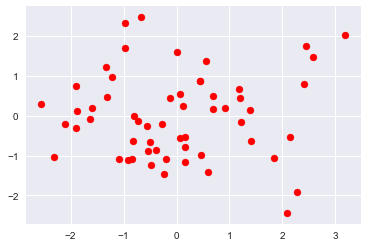

In [88]:
#plt.scatter(x_train_new)
plt.scatter(x_pca_tsform[:,0],x_pca_tsform[:,1], c='red')


In [89]:
pca_df=pd.DataFrame(pca.components_, columns=x_train_new.columns, index=['PCA-1', 'PCA-2']).T

In [90]:
pca_df['PCA-1'].reindex(pca_df['PCA-1'].abs().sort_values(inplace=False, ascending=False).index)

HI_ratio                                 4.288603e-01
Race[T.White]                           -4.177177e-01
unemployment_rate                        3.740989e-01
County[T.Harris County, TX]             -3.163527e-01
County[T.Philadelphia County, PA]        3.036212e-01
County[T.Wayne County, MI]               2.814845e-01
County[T.Dallas County, TX]             -2.473255e-01
Year                                     1.847053e-01
County[T.Baltimore city, MD]             1.709588e-01
County[T.Tarrant County, TX]            -1.307085e-01
Gender[T.Male]                           1.226842e-01
County[T.Bexar County, TX]              -9.328188e-02
County[T.San Diego County, CA]          -8.917493e-02
County[T.Shelby County, TN]              8.894918e-02
County[T.Will County, IL]               -8.678171e-02
County[T.Oklahoma County, OK]           -7.634989e-02
County[T.Milwaukee County, WI]           7.416549e-02
County[T.Caddo Parish, LA]               6.892000e-02
County[T.Jefferson County, A

In [91]:
pca_df['PCA-2'].reindex(pca_df['PCA-2'].abs().sort_values(inplace=False, ascending=False).index)

HI_ratio                                 0.507781
unemployment_rate                       -0.360775
Year                                     0.359450
County[T.Maricopa County, AZ]            0.341618
Race[T.White]                            0.271826
County[T.Wayne County, MI]              -0.208818
County[T.Queens County, NY]              0.183890
County[T.Hillsborough County, FL]        0.155691
County[T.Worcester County, MA]           0.152047
County[T.Philadelphia County, PA]        0.144770
County[T.Shelby County, TN]             -0.126839
County[T.Marion County, IN]             -0.117745
County[T.Cook County, IL]               -0.117317
County[T.Kings County, NY]              -0.103564
County[T.Bronx County, NY]              -0.100855
Gender[T.Male]                          -0.096324
County[T.Dallas County, TX]             -0.090858
County[T.District of Columbia, DC]      -0.084829
County[T.Bexar County, TX]               0.083993
County[T.Los Angeles County, CA]        -0.080521


# Tree

In [92]:
dt_test_sc = []
dt_train_sc = []

for n in range(1,21):
    DT_reg = DecisionTreeRegressor(max_depth=n)

    train = DT_reg.fit(x_train_new, y_train_new).score(x_train_new, y_train_new)
    dt_train_sc.append(train)
    
    test = DT_reg.fit(x_test_new, y_test_new).score(x_test_new, y_test_new)
    dt_test_sc.append(test)
    

/Users/allandong/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


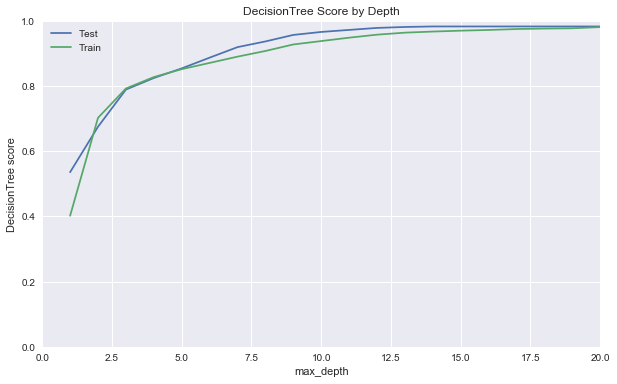

In [93]:
plt.figure(figsize=(10,6))
plt.ylim(0,1)
plt.xlim(0,20)
plt.legend()

plt.plot(range(1,21), dt_test_sc, label='Test')
plt.plot(range(1,21), dt_train_sc, label='Train')
plt.title('DecisionTree Score by Depth')
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('DecisionTree score')
plt.show()

In [94]:
reg1 = DecisionTreeRegressor(max_depth=2)
reg2 = DecisionTreeRegressor(max_depth=10)

reg1.fit(x_train_new, y_train_new)
reg2.fit(x_train_new, y_train_new)

reg_y1 = reg1.predict(x_test_new)
reg_y2 = reg2.predict(x_test_new)

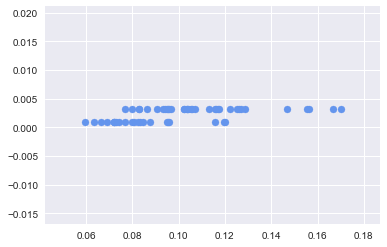

In [95]:
plt.figure()
#plt.scatter(new_x, new_y, c='darkorange')
plt.scatter(x_test_new.HI_ratio, reg_y1, color='cornflowerblue')
#plt.plot(x_test_std, reg_y2, color='yellowgreen')

In [96]:
reg2.score(x_test_new, y_test_new)

0.61628910657607694

In [97]:
reg2.score(x_train_new, y_train_new)

0.93723190340618301

In [99]:
RF_test_sc = []
RF_train_sc = []

for n in range(1,21):
    RF_reg = RandomForestRegressor(max_depth=n)

    train = RF_reg.fit(x_train_new, y_train_new).score(x_train_new, y_train_new)
    RF_train_sc.append(train)
    
    test = RF_reg.fit(x_test_new, y_test_new).score(x_test_new, y_test_new)
    RF_test_sc.append(test)
    

/Users/allandong/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


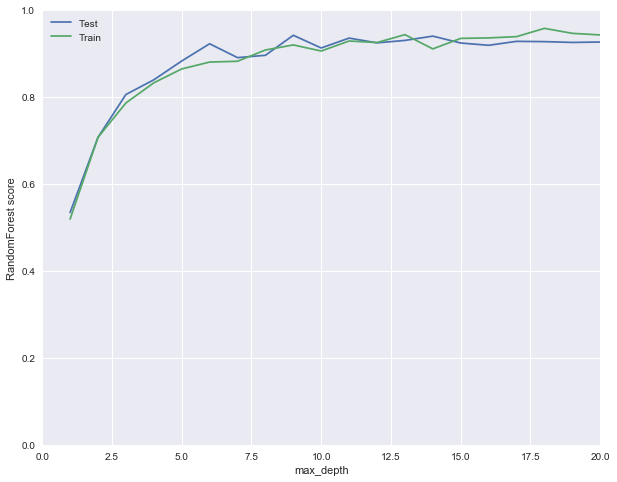

In [442]:
plt.figure(figsize=(10,8))
plt.ylim(0,1)
plt.xlim(0,20)
plt.legend()

plt.plot(range(1,21), RF_test_sc, label='Test')
plt.plot(range(1,21), RF_train_sc, label='Train')

plt.legend()
plt.xlabel('max_depth')
plt.ylabel('RandomForest score')
plt.show()

In [101]:
RF_reg1 = RandomForestRegressor(max_depth=2)
RF_reg2 = RandomForestRegressor(max_depth=10)

RF_reg1.fit(x_train_new, y_train_new)
RF_reg2.fit(x_train_new, y_train_new)



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [102]:
RF_reg2.score(x_test_new, y_test_new)

0.70950236346557671

In [103]:
RF_reg2.score(x_train_new, y_train_new)

0.92378596213536768

In [110]:
DT_features = reg2.feature_importances_
RF_features = RF_reg2.feature_importances_

df_feat = pd.DataFrame([DT_features, RF_features], columns = x_train_new.columns, index=['DecisionTree', 'RandomForest']).T

In [118]:
df_feat['DecisionTree'].reindex(df_feat['DecisionTree'].sort_values(inplace=False, ascending=False).index)

Race[T.White]                            0.428472
County[T.Caddo Parish, LA]               0.299904
County[T.Mobile County, AL]              0.057862
County[T.Philadelphia County, PA]        0.028271
County[T.St. Louis city, MO]             0.027241
HI_ratio                                 0.026335
County[T.East Baton Rouge Parish, LA]    0.022341
Gender[T.Male]                           0.022206
County[T.Jefferson County, AL]           0.013439
County[T.Los Angeles County, CA]         0.012408
County[T.Worcester County, MA]           0.011707
County[T.Harris County, TX]              0.010170
County[T.Cuyahoga County, OH]            0.007689
County[T.Baltimore city, MD]             0.005097
County[T.Oklahoma County, OK]            0.005042
County[T.Milwaukee County, WI]           0.004954
County[T.Will County, IL]                0.003534
County[T.Marion County, IN]              0.003083
unemployment_rate                        0.003004
County[T.Dallas County, TX]              0.002683


In [112]:
df_feat['RandomForest'].reindex(df_feat['RandomForest'].sort_values(inplace=False, ascending=False).index)

County[T.Caddo Parish, LA]               0.386873
Race[T.White]                            0.348226
County[T.Mobile County, AL]              0.043082
County[T.Philadelphia County, PA]        0.030213
HI_ratio                                 0.024449
unemployment_rate                        0.021993
County[T.St. Louis city, MO]             0.021805
County[T.Jefferson County, AL]           0.019123
County[T.East Baton Rouge Parish, LA]    0.018013
Gender[T.Male]                           0.014946
Year                                     0.009763
County[T.Cuyahoga County, OH]            0.008802
County[T.Milwaukee County, WI]           0.008755
County[T.Worcester County, MA]           0.007512
County[T.Baltimore city, MD]             0.007413
County[T.Los Angeles County, CA]         0.004912
County[T.Dallas County, TX]              0.004328
County[T.Oklahoma County, OK]            0.004181
County[T.Cook County, IL]                0.003603
County[T.Hamilton County, OH]            0.003121


# Rerunning with New CDC/Additional Data

In [2]:
labor = ref.Home + '/labor.csv'
hi = ref.Home + '/HI.csv'

df_labor = pd.read_csv(labor, dtype={'series_id' : str, 
                                     'year' : int, 
                                     'period' : str, 
                                     'value' : object,
                                     'footnote_codes' : str,
                                     'area_code': str,
                                     'series_title' : str,
                                     'area_text' : str})
df_hi = pd.read_csv(hi)

/Users/allandong/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_labor_cty = df_labor[df_labor.area_code.str.find(r'CN') != -1]

In [4]:
df_labor_cty['FIPS'] = df_labor_cty['area_code'].map(lambda x: int(x[2:7]))
df_labor_cty_yr = df_labor_cty[df_labor_cty.period == 'M13']

/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [5]:
df_labor_HI = pd.merge(df_labor_cty_yr, df_hi, 
                       how='inner', 
                       left_on=['year', 'FIPS'], 
                       right_on=['Year', 'Id2'])

In [6]:
racegender = ref.Home + '/CDC_racegender.csv'

df_rg = pd.read_csv(racegender, dtype={'County Code' : int})

In [7]:
rg_columns = ['County', 'County_Code', 'Race', 'Race_Code', 'Gender', 'Gender_Code', 
                'Deaths', 'Births', 'Death_Rate', 'Year']
df_rg.columns = rg_columns

df_rg.replace(to_replace='Missing', value=np.nan, inplace=True)
df_rg.dropna(axis=0, how='any')

df_rg['Deaths'] = pd.to_numeric(df_rg.Deaths)
df_rg['Births'] = pd.to_numeric(df_rg.Births)
df_rg['Death_ratio'] = df_rg['Deaths']/df_rg['Births']

df_rg.drop(['Death_Rate', 'Race_Code', 'Gender_Code', 'Death_Rate'], axis=1, inplace=True)


In [8]:
County_Classifications = ref.Home + '/County_Classifications.csv'
People = ref.Home + '/People.csv'
Veterans = ref.Home + '/Veterans.csv'
Income = ref.Home + 'Income.csv'

df_cty_class = pd.read_csv(County_Classifications, encoding = "ISO-8859-1", dtype={'FIPS':int})
df_people = pd.read_csv(People, encoding = "ISO-8859-1", dtype={'FIPS':int})
df_veterans = pd.read_csv(Veterans, encoding = "ISO-8859-1", dtype={'FIPS':int})
df_income = pd.read_csv(Income, encoding = "ISO-8859-1", dtype={'FIPS':int})

In [9]:
df_cty_industry = df_cty_class[['FIPS', 
                                'Type_2015_Farming_NO',
                                'Type_2015_Manufacturing_NO',
                                'Type_2015_Mining_NO',
                                'Type_2015_Government_NO', 
                                'Type_2015_Recreation_NO', 
                                'Type_2015_Nonspecialized_NO']]

In [10]:
df_cty_type = df_cty_class[['FIPS', 
                            'Metro2013', 
                            'Nonmetro2013',
                            'Micropolitan2013',
                            'Noncore2013',
                            'Metro_Adjacent2013' ]]

In [11]:
df_ed = df_people[['FIPS', 
                   'Ed1LessThanHSPct', 
                   'Ed2HSDiplomaOnlyPct', 
                   'Ed3SomeCollegePct',
                   'Ed4AssocDegreePct', 
                   'Ed5CollegePlusPct']]

In [12]:
df_poverty = df_income[['FIPS', 
                        'Deep_Pov_All']]

In [13]:
df_vets = df_veterans[['FIPS', 
                       'Vets18OPct']]

In [14]:
df_ex1 = pd.merge(df_poverty, df_vets, how='inner', on=['FIPS'])
df_ex2 = pd.merge(df_ex1, df_ed, how='inner', on=['FIPS'])
df_ex3 = pd.merge(df_ex2, df_cty_industry, how='inner', on=['FIPS'])
df_ex4 = pd.merge(df_ex3, df_cty_type, how='inner', on=['FIPS'])

In [15]:
df_ex5 = pd.merge(df_ex4, df_labor_HI, how='inner', on=['FIPS'])

In [16]:
df3 = pd.merge(df_rg, df_ex5,
             how='inner',
             left_on=['Year', 'County_Code'],
             right_on=['Year', 'FIPS'])

In [17]:
# Categoricals
df3_county = patsy.dmatrix('County', data=df3, return_type='dataframe').drop('Intercept', 1)
df3_race = patsy.dmatrix('Race', data=df3, return_type='dataframe').drop('Intercept', 1)
df3_gender = patsy.dmatrix('Gender', data=df3, return_type='dataframe').drop('Intercept', 1)
df3_year = patsy.dmatrix('Year', data=df3, return_type='dataframe').drop('Intercept', 1)
df3_cty_industry = df3[['Type_2015_Farming_NO',
                                'Type_2015_Manufacturing_NO',
                                'Type_2015_Mining_NO',
                                'Type_2015_Government_NO', 
                                'Type_2015_Recreation_NO', 
                                'Type_2015_Nonspecialized_NO']]
df3_cty_type = df3[['Metro2013', 
                            'Nonmetro2013',
                            'Micropolitan2013',
                            'Noncore2013',
                            'Metro_Adjacent2013']]


In [18]:
df3_std = df3.drop(['County', 'County_Code', 'Race', 'Gender', 'Deaths', 'Births', 'Year',
       'FIPS', 'Type_2015_Farming_NO',
       'Type_2015_Manufacturing_NO', 'Type_2015_Mining_NO',
       'Type_2015_Government_NO', 'Type_2015_Recreation_NO',
       'Type_2015_Nonspecialized_NO', 'Metro2013', 'Nonmetro2013',
       'Micropolitan2013', 'Noncore2013', 'Metro_Adjacent2013', 'series_id',
       'year', 'period', 'footnote_codes', 'area_code',
       'series_title', 'area_text', 'Id', 'Id2', 'Geography',
       'Est_total_pop',
       'Est_1_HI_pop', 'Est_0_HI_pop'], axis=1)

In [19]:
x_df3 = df3_std.drop('Death_ratio', axis=1)
y_df3 = df3_std['Death_ratio']

x_train_df3, x_test_df3, y_train_df3, y_test_df3 = train_test_split(x_df3, 
                                                                    y_df3, 
                                                                    test_size=0.25, 
                                                                    random_state=20)

In [20]:
df3_std1 = pd.concat([df3_std,
                     df3_county,
                     #df3_race,
                     df3_gender,
                     df3_year,
                     df3_cty_industry,
                     df3_cty_type], axis=1, join='inner')

# df3_std1_filename = ref.Home + '/Final_df.csv'
# df3_std1.to_csv(df3_std1_filename, index_label=False)
df3_std1.shape

(3371, 262)

In [21]:
x_df3_full = df3_std1.drop('Death_ratio', axis=1)
y_df3_full = df3_std1['Death_ratio']

x_train_df3_full, x_test_df3_full, y_train_df3_full, y_test_df3_full = train_test_split(x_df3_full, 
                                                                                        y_df3_full,
                                                                                        test_size=0.25, 
                                                                                        random_state=42)

In [22]:
df3_patsy = df3_std1.drop(['Death_ratio',
                           'Deep_Pov_All',
                          'Vets18OPct',
                          'Ed1LessThanHSPct',
                          'Ed2HSDiplomaOnlyPct',
                          'Ed3SomeCollegePct', 
                          'Ed4AssocDegreePct', 
                          'Ed5CollegePlusPct',
                          'unemployment_rate',
                          'HI_ratio'], axis=1)
x_train_df3_patsy, x_test_df3_patsy = train_test_split(df3_patsy, test_size=0.25, random_state=20)


x_train_df3_patsy.reset_index(inplace=True)
x_train_df3_patsy.drop('index', axis=1, inplace=True)
x_test_df3_patsy.reset_index(inplace=True)
x_test_df3_patsy.drop('index', axis=1, inplace=True)

/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
ss = StandardScaler()
ss.fit(x_train_df3)

ss_x_df3_train = ss.transform(x_train_df3)
ss_x_df3_test = ss.transform(x_test_df3)

df_ss_x_df3_train = pd.DataFrame(ss_x_df3_train, columns = ['Deep_Pov_All', 
                                                            'Vets18OPct',
                                                            'Ed1LessThanHSPct', 
                                                            'Ed2HSDiplomaOnlyPct',
                                                            'Ed3SomeCollegePct',
                                                            'Ed4AssocDegreePct',
                                                            'Ed5CollegePlusPct',
                                                            'unemployment_rate', 
                                                            #'Est_total_pop', 
                                                            'HI_ratio'])
df_ss_x_df3_test = pd.DataFrame(ss_x_df3_test, columns = ['Deep_Pov_All',
                                                          'Vets18OPct',
                                                          'Ed1LessThanHSPct',
                                                          'Ed2HSDiplomaOnlyPct',
                                                          'Ed3SomeCollegePct', 
                                                          'Ed4AssocDegreePct', 
                                                          'Ed5CollegePlusPct',
                                                          'unemployment_rate',
                                                          #'Est_total_pop', 
                                                          'HI_ratio'])

df_x_df3_train_std = pd.concat([df_ss_x_df3_train, x_train_df3_patsy], axis=1)
df_x_df3_train_std['intercept'] = np.ones(len(df_x_df3_train_std))

df_x_df3_test_std = pd.concat([df_ss_x_df3_test, x_test_df3_patsy], axis=1)
df_x_df3_test_std['intercept'] = np.ones(len(df_x_df3_test_std))

In [24]:
#  Linear Regression
lr = LinearRegression()
lr.fit(df_x_df3_train_std, y_train_df3)
lrpredict=lr.predict(df_x_df3_test_std)

In [25]:
lr.score(df_x_df3_train_std, y_train_df3)

0.37413889673197859

In [26]:
lr.score(df_x_df3_test_std, y_test_df3)

-7.2313430970053001e+19

In [27]:
# Ridge Regression
ridge = Ridge()
ridge.fit(df_x_df3_train_std, y_train_df3)
ridgepredict = ridge.predict(df_x_df3_test_std)

In [28]:
ridge.score(df_x_df3_train_std, y_train_df3)

0.36980174942049399

In [29]:
ridge.score(df_x_df3_test_std, y_test_df3)

0.23656112860905595

# Second Tree

In [30]:
dt_test_sc2 = []
dt_train_sc2 = []

for n in range(1,31):
    DT_reg = DecisionTreeRegressor(max_depth=n)

    train = DT_reg.fit(x_train_df3_full, y_train_df3_full).score(x_train_df3_full, y_train_df3_full)
    dt_train_sc2.append(train)
    
    test = DT_reg.fit(x_test_df3_full, y_test_df3_full).score(x_test_df3_full, y_test_df3_full)
    dt_test_sc2.append(test)
    

/Users/allandong/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


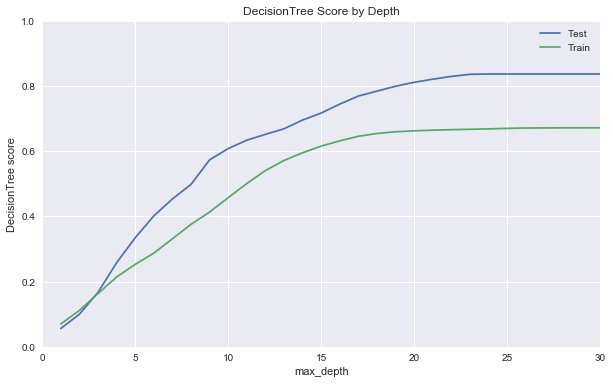

In [31]:
plt.figure(figsize=(10,6))
plt.ylim(0,1)
plt.xlim(0,30)
plt.legend()

plt.plot(range(1,31), dt_test_sc2, label='Test')
plt.plot(range(1,31), dt_train_sc2, label='Train')
plt.title('DecisionTree Score by Depth')
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('DecisionTree score')
plt.show()

In [32]:
DT2_1 = DecisionTreeRegressor(max_depth=2)
DT2_2 = DecisionTreeRegressor(max_depth=20)

DT2_1.fit(x_train_df3_full, y_train_df3_full)
DT2_2.fit(x_train_df3_full, y_train_df3_full)

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [33]:
DT2_2.score(x_train_df3_full, y_train_df3_full)

0.66205689699533798

In [34]:
DT2_2.score(x_test_df3_full, y_test_df3_full)

-0.69342536700599222

In [35]:
RF_test_sc2 = []
RF_train_sc2 = []

for n in range(1,31):
    RF_reg = RandomForestRegressor(n_estimators=10, max_depth=n)

    train = RF_reg.fit(x_train_df3_full, y_train_df3_full).score(x_train_df3_full, y_train_df3_full)
    RF_train_sc2.append(train)
    
    test = RF_reg.fit(x_test_df3_full, y_test_df3_full).score(x_test_df3_full, y_test_df3_full)
    RF_test_sc2.append(test)
    

/Users/allandong/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


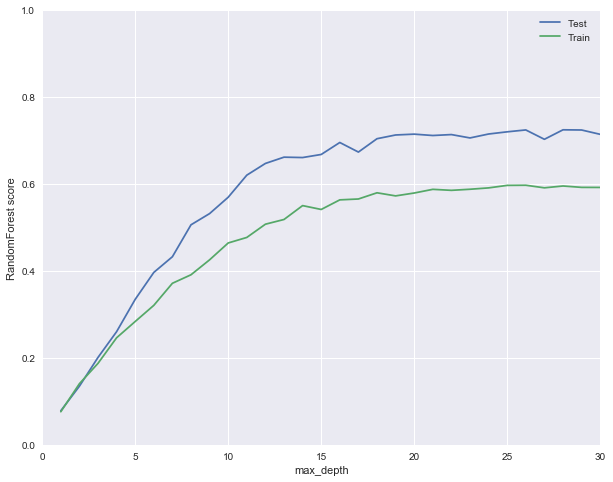

In [36]:
plt.figure(figsize=(10,8))
plt.ylim(0,1)
plt.xlim(0,30)
plt.legend()

plt.plot(range(1,31), RF_test_sc2, label='Test')
plt.plot(range(1,31), RF_train_sc2, label='Train')

plt.legend()
plt.xlabel('max_depth')
plt.ylabel('RandomForest score')
plt.show()

In [37]:
RF2_reg1 = RandomForestRegressor(max_depth=2)
RF2_reg2 = RandomForestRegressor(n_estimators = 50, max_depth=20, max_features='auto', oob_score=True)

RF2_reg1.fit(x_train_df3_full, y_train_df3_full)
RF2_reg2.fit(x_train_df3_full, y_train_df3_full)



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [38]:
RF2_reg2.score(x_train_df3_full, y_train_df3_full)

0.61276373608597101

In [39]:
RF2_reg2.score(x_test_df3_full, y_test_df3_full)

-0.19905152426425032

In [40]:
RF2_reg2.oob_score_

-0.18508638299778601

In [41]:
DT2_features = DT2_2.feature_importances_
RF2_features = RF2_reg2.feature_importances_

df_feat2 = pd.DataFrame([DT2_features, RF2_features], columns = x_train_df3_full.columns, index=['DecisionTree', 'RandomForest']).T

In [42]:
df_feat2['DecisionTree'].reindex(df_feat2['DecisionTree'].sort_values(inplace=False, ascending=False).index)

Deep_Pov_All                          0.191557
HI_ratio                              0.120661
unemployment_rate                     0.109487
Vets18OPct                            0.087411
Gender[T.Male]                        0.072796
Year                                  0.068780
Ed4AssocDegreePct                     0.059071
Ed2HSDiplomaOnlyPct                   0.057291
Ed5CollegePlusPct                     0.045494
Ed1LessThanHSPct                      0.027819
Ed3SomeCollegePct                     0.027524
County[T.Mercer County, NJ]           0.020886
County[T.Caddo Parish, LA]            0.016688
County[T.Madison County, AL]          0.013553
County[T.San Francisco County, CA]    0.012467
County[T.Atlantic County, NJ]         0.010679
County[T.Delaware County, PA]         0.008793
County[T.Fulton County, GA]           0.008180
County[T.Hamilton County, TN]         0.004429
Type_2015_Nonspecialized_NO           0.003598
County[T.Essex County, NJ]            0.003466
County[T.Cook

In [43]:
df_feat2['RandomForest'].reindex(df_feat2['RandomForest'].sort_values(inplace=False, ascending=False).index)

Deep_Pov_All                          1.609299e-01
HI_ratio                              1.275083e-01
unemployment_rate                     1.174682e-01
Year                                  7.840145e-02
Gender[T.Male]                        7.477395e-02
Vets18OPct                            7.399847e-02
Ed1LessThanHSPct                      5.157173e-02
Ed2HSDiplomaOnlyPct                   4.870280e-02
Ed4AssocDegreePct                     3.764793e-02
Ed5CollegePlusPct                     3.033044e-02
Ed3SomeCollegePct                     2.832529e-02
County[T.Mercer County, NJ]           1.622504e-02
County[T.San Francisco County, CA]    1.407051e-02
County[T.Madison County, AL]          9.773212e-03
County[T.Atlantic County, NJ]         9.305720e-03
County[T.Caddo Parish, LA]            8.315191e-03
County[T.Delaware County, PA]         7.254471e-03
County[T.Fresno County, CA]           5.546942e-03
County[T.Hamilton County, TN]         4.276210e-03
Type_2015_Nonspecialized_NO    

In [46]:
gp_race = df_rg.groupby(['Year', 'County','Race']).agg({'Births':'first','Deaths':'sum'})
gp_race['Death_ratio'] = gp_race['Deaths']/gp_race['Births']

TypeError: '<=' not supported between instances of 'float' and 'str'

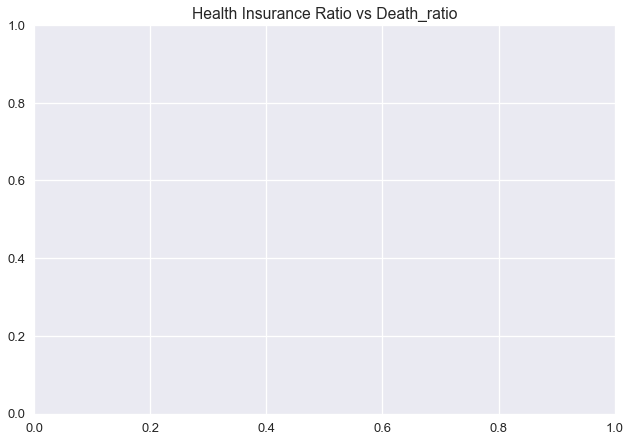

In [47]:

plt.title('Health Insurance Ratio vs Death_ratio')
sns.set_context('talk')

sns.regplot((df3_std['unemployment_rate']), df3_std.Death_ratio, logx=True)

In [ ]:
#### x_hi = df3_std.HI_ratio
y_hi = df3_std.Death_ratio

x_hi_train, x_hi_test, y_hi_train, y_hi_test = train_test_split(x_hi, y_hi, 
                                                                test_size=0.25,
                                                                random_state=20
                                                           )

In [273]:
# lr=LinearRegression()
# lr.fit(x_hi_train, y_hi_train)
# lr.predict(x_hi_test)
# lr.score(x_hi_test, y_hi_test)

/Users/allandong/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: Found input variables with inconsistent numbers of samples: [1, 2528]

In [271]:
x_hi_test.shape

(843,)

In [272]:
y_hi_test.shape

(843,)